In [1]:
import os
import os.path as osp

import numpy as np
import pandas as pd

In [2]:
date = "2024-07-29"
df = pd.read_csv(f"data/{date}.csv")
for col in df.columns:
    print(col, df[col].dtype)
print("\nnumber of records", len(df))

record_id object
longitude float64
latitude float64
speed float64
heading int64
navigation_status float64
mmsi int64
ship_type float64
ship_name float64
timestamp object
decode_timestamp object
data_timestamp object
day_id int64
date object
unixstamp float64

number of records 6517


In [3]:
print("number of ships", df["mmsi"].nunique(), df["mmsi"].unique())

number of ships 10 [413867644 413837923 413837924 413860512 413848169 413837927 413866992
 413863924 413859423 413841065]


In [4]:
from collections import defaultdict

ship_gis = defaultdict(list)
for mmsi in df["mmsi"].unique():
    filtered_df = df[df["mmsi"] == mmsi]
    mmsi = str(mmsi)
    for idx, row in filtered_df.iterrows():
        ship_gis[mmsi].append(tuple(row[col] for col in ["longitude", "latitude", "unixstamp"]))
    ship_gis[mmsi] = np.array(ship_gis[mmsi])
    ship_gis[mmsi] = ship_gis[mmsi][np.argsort(ship_gis[mmsi][:, 2])] # sort according to the timestamp

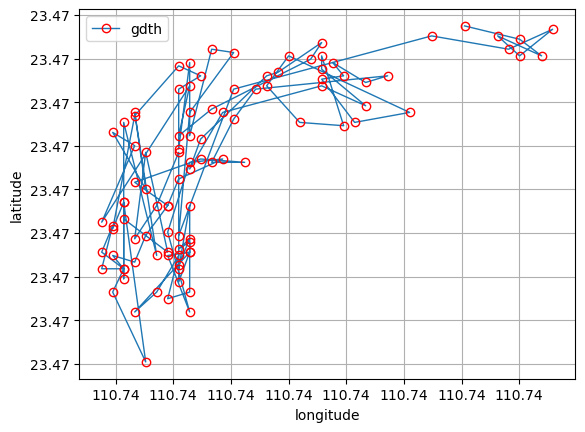

In [5]:
import matplotlib
import matplotlib.pyplot as plt

def draw_xy(x, y):
    fig = plt.figure()
    plt.plot(x, y, linestyle='-', linewidth=1, marker='o', markerfacecolor='none', markeredgecolor='red', label="gdth")
    plt.grid(True)
    plt.legend()
    # 设置 X 轴刻度
    plt.gca().xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(nbins=10))  # 设置最多 10 个刻度
    # 设置 X 轴刻度格式化器
    plt.gca().xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.2f'))  # 保留两位小数
    # 设置 Y 轴刻度
    plt.gca().yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(nbins=10))  # 设置最多 10 个刻度
    # 设置 Y 轴刻度格式化器
    plt.gca().yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.2f'))  # 保留两位小数
    plt.xlabel("longitude")
    plt.ylabel("latitude")
    plt.show()


start = 100
winsz = 100

data = ship_gis["413848169"][start:start + winsz]
x = data[:, 0]
y = data[:, 1]
draw_xy(x, y)

In [6]:
import numpy as np

class KDTree(object):
    
    """
    A super short KD-Tree for points...
    so concise that you can copypasta into your homework 
    without arousing suspicion.

    This implementation only supports Euclidean distance. 

    The points can be any array-like type, e.g: 
        lists, tuples, numpy arrays.

    Usage:
    1. Make the KD-Tree:
        `kd_tree = KDTree(points, dim)`
    2. You can then use `get_knn` for k nearest neighbors or 
        `get_nearest` for the nearest neighbor

    points are be a list of points: [[0, 1, 2], [12.3, 4.5, 2.3], ...]
    """
    def __init__(self, points, dist_sq_func=None):
        """Makes the KD-Tree for fast lookup.

        Parameters
        ----------
        points : list<point>
            A list of points.
        dim : int 
            The dimension of the points. 
        dist_sq_func : function(point, point), optional
            A function that returns the squared Euclidean distance
            between the two points. 
            If omitted, it uses the default implementation.
        """
        # do the dimension check
        assert len(points) > 0, "empty point set"
        if not isinstance(points, np.ndarray):
            dim = len(points[0])
            for point in points:
                assert len(point) == dim
        if isinstance(points, np.ndarray):
            assert len(points.shape) == 2
            points = list(points)
        
        dim = len(points[0])

        # bind each point with its original index
        points = [(point, i) for i, point in enumerate(points)]

        if dist_sq_func is None:
            dist_sq_func = lambda a, b: sum((x - b[i]) ** 2 for i, x in enumerate(a))
        
        def build(points, sort_dim=0):
            if len(points) == 0:
                return None
            if len(points) == 1:
                return [None, None, points[0]]

            points.sort(key=lambda x: x[0][sort_dim])
            sort_dim = (sort_dim + 1) % dim
            m = len(points) >> 1
            return [build(points[:m], sort_dim), build(points[m + 1:], sort_dim), points[m]]
        
        def add_point(node, point, i=0):
            if node is not None:
                dx = node[2][0][i] - point[0][i]
                for j, c in ((0, dx >= 0), (1, dx < 0)):
                    if c and node[j] is None:
                        node[j] = [None, None, point]
                    elif c:
                        add_point(node[j], point, (i + 1) % dim)

        import heapq
        def get_knn(node, query, k: int, heap, i=0, levelidx=1):
            if node is None:
                return
                
            dist_sq = dist_sq_func(query, node[2][0])
            if len(heap) < k:
                heapq.heappush(heap, (-dist_sq, levelidx, node[2]))
            elif dist_sq < -heap[0][0]:
                heapq.heappushpop(heap, (-dist_sq, levelidx, node[2]))
            

            dx = node[2][0][i] - query[i]
            i = (i + 1) % dim
            # Goes into one branch then the other
            for b in (int(dx < 0), int(dx >= 0))[:1 + (dx * dx < -heap[0][0])]:
                get_knn(node[b], query, k, heap, i, (levelidx << 1) | b)
            
            # backtrack to top root
            if levelidx == 1:
                sorted_heap = sorted(heap)[::-1]
                neigh = [he[2][0] for he in sorted_heap]
                distt = [-he[0] for he in sorted_heap]
                index = [he[2][1] for he in sorted_heap]
                return neigh, distt, index

        def walk(node):
            if node is not None:
                for x in walk(node[0]):
                    yield x
                yield node[2]
                for x in walk(node[1]):
                    yield x

        self._root = build(points)
        self._add_point = add_point
        self._get_knn = get_knn 
        self._walk = walk

    def __iter__(self):
        return self._walk(self._root)
        
    def add_point(self, point):
        """Adds a point to the kd-tree.
        
        Parameters
        ----------
        point : array-like
            The point.
        """
        if self._root is None:
            self._root = [None, None, point]
        else:
            self._add_point(self._root, point)

    def get_knn(self, point, k: int):
        """Returns k nearest neighbors.

        Parameters
        ----------
        point : array-like
            The point.
        k: int 
            The number of nearest neighbors.
        return_dist_sq : boolean
            Whether to return the squared Euclidean distances.

        Returns
        -------
        list<array-like>
            The nearest neighbors. 
            If `return_dist_sq` is true, the return will be:
                [(dist_sq, point), ...]
            else:
                [point, ...]
        """
        return self._get_knn(self._root, point, k, [])

    def get_nearest(self, point):
        """Returns the nearest neighbor.

        Parameters
        ----------
        point : array-like
            The point.
        return_dist_sq : boolean
            Whether to return the squared Euclidean distance.

        Returns
        -------
        array-like
            The nearest neighbor. 
            If the tree is empty, returns `None`.
            If `return_dist_sq` is true, the return will be:
                (dist_sq, point)
            else:
                point
        """
        return self._get_knn(self._root, point, 1, [])


In [7]:
search_tree = KDTree(data[:, :2])

neigh, distt, index = search_tree.get_knn(data[0, :2], 5)

[array([110.74172211,  23.46624374]), array([110.74169922,  23.46623802]), array([110.741745  ,  23.46623802]), array([110.74175262,  23.46623039]), array([110.74176025,  23.46623611])]
[0.0, 5.566107575256897e-10, 5.56610758176211e-10, 1.1095835362578401e-09, 1.5133991826117403e-09]
[0, 7, 3, 6, 1]


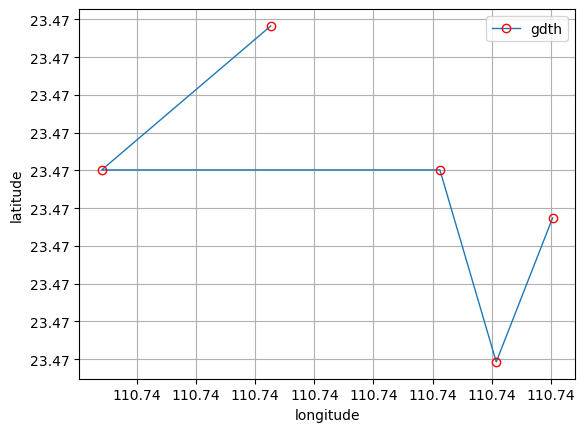

In [10]:
print(neigh)
print(distt)
print(index)
data = np.array(neigh)
x = data[:, 0]
y = data[:, 1]
draw_xy(x, y)

In [9]:
def pca_k(data, k: int):
    if not isinstance(data, np.ndarray):
        try:
            data = np.array(data)
        except Exception as e:
            print("failed to convert to np.ndarray")
    
    # centralized
    data = data - data.mean(axis=0)
    
    # covariance
    cova = np.cov(data, rowvar=False)
    # for rowvar=True, data must be:
    # [
    #     [x1, x2, x3, ...]
    #     [y1, y2, y3, ...]
    # ]
    # thus each column is a point and each row is a variable

    eigvals, eigvecs = np.linalg.eig(cova)

    sorted_indices = np.argsort(eigvals)[::-1]
    eigvals = eigvals[sorted_indices]
    eigvecs = eigvecs[:, sorted_indices]

    return eigvals[:k], eigvecs[:, :k]

